## Dependencias 

In [65]:
import numpy as np 
import pandas as pd 

import matplotlib.pyplot as plt
import seaborn as sns
import cufflinks as cf

from scipy import stats 
from varclushi import VarClusHi

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier 
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import roc_auc_score
from sklearn.feature_selection import SelectKBest

from CreditScoringToolkit.frequency_table import frequency_table

from functools import reduce

import warnings
warnings.filterwarnings('ignore')
cf.go_offline()

## Cargar Datos

In [31]:
data = pd.read_csv('../data/churn_taxi.zip')
data.shape

(1438874, 13)

In [32]:
data.head()

,id_taxi,fh_mes,d_debajo_prom_ing,c_ticket_prom,c_num_meses_activo,c_prom_ing_mes_c_prop,c_prom_ing_mes_s_prop,c_pct_viajes_malos,c_distancia_promedio,d_empresa,c_pct_cash,fuga,d_mes
0,1,2015-03-01,True,41.118113,5,363.210000,361.210000,0.094340,0.00000,OTRA,0.000000,0,3
1,1,2015-05-01,True,41.621228,6,395.401667,392.235000,0.122807,0.00000,OTRA,0.000000,0,5
2,1,2015-11-01,True,50.869524,4,356.086667,318.743333,0.054545,0.00000,OTRA,0.000000,0,11
3,1,2015-12-01,True,50.421961,5,428.586667,391.243333,0.018182,0.00000,OTRA,0.000000,0,12
4,1,2016-01-01,True,23.660963,6,532.371667,465.310000,0.607407,3.57963,OTRA,0.407898,1,1


## Partición

In [33]:
train, valid = train_test_split(data, test_size=0.3, random_state=42)
train.reset_index(drop=True, inplace=True)
valid.reset_index(drop=True, inplace=True)
train.shape, valid.shape

((1007211, 13), (431663, 13))

In [34]:
full = train.copy()
train = train.sample(5000, random_state=42).reset_index(drop=True)

## Naturaleza de variables 

In [35]:
um = ['id_taxi','fh_mes']
varc = [v for v in data.columns if v[:2]=='c_']
vard = [v for v in data.columns if v[:2]=='d_']
vart = ['fuga']
len(varc),len(vard)

(7, 3)

In [36]:
# Validación de representatividad de la muestra
for v in varc:
    print(v, stats.ks_2samp(train[v].dropna(), full[v].dropna()).statistic)

c_ticket_prom 0.011287350316865119
c_num_meses_activo 0.01089870225801745
c_prom_ing_mes_c_prop 0.018583002171342455
c_prom_ing_mes_s_prop 0.017234965265470692
c_pct_viajes_malos 0.011354999275264621
c_distancia_promedio 0.01316878016213352
c_pct_cash 0.009508837762196465


## Análisis Exploratorio de datos 

### Continuo 

#### Ausentes

In [37]:
train[varc].isna().sum()/len(train)

c_ticket_prom            0.0000
c_num_meses_activo       0.0000
c_prom_ing_mes_c_prop    0.0000
c_prom_ing_mes_s_prop    0.0000
c_pct_viajes_malos       0.0192
c_distancia_promedio     0.0192
c_pct_cash               0.0194
dtype: float64

In [38]:
im = SimpleImputer(strategy='median')

In [39]:
im.fit(train[varc])

SimpleImputer(strategy='median')

In [40]:
Xt = train[um+varc].copy()

In [41]:
Xt[varc] = im.transform(Xt[varc])

In [42]:
Xt.dropna().shape,Xt.shape

((5000, 9), (5000, 9))

In [43]:
for v in varc:
    print(v,stats.ks_2samp(train[v].dropna(),Xt[v]).statistic)


c_ticket_prom 0.0
c_num_meses_activo 0.0
c_prom_ing_mes_c_prop 0.0
c_prom_ing_mes_s_prop 0.0
c_pct_viajes_malos 0.0096
c_distancia_promedio 0.0096
c_pct_cash 0.009698021619416684


#### Multicolinealidad 

In [44]:
vc = VarClusHi(Xt,feat_list=varc).varclus()
mc = list(vc.rsquare.sort_values(by=['Cluster','RS_Ratio']).groupby('Cluster').first()['Variable'])
mc

['c_pct_viajes_malos', 'c_prom_ing_mes_c_prop']

#### Extremos

array([[<Axes: title={'center': 'c_pct_viajes_malos'}>,
        <Axes: title={'center': 'c_prom_ing_mes_c_prop'}>]], dtype=object)

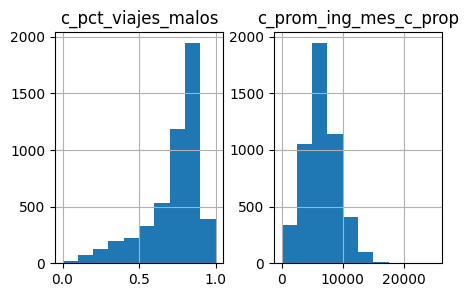

In [45]:
Xt[mc].hist(figsize=(5,3))

In [46]:
for v,li,ls in Xt[mc].describe(percentiles=[0.01,0.99]).T[['1%','99%']].reset_index().values:
    Xt[f'ex_{v}'] =((Xt[v]<li)|(Xt[v]>ls)).astype(int)
Xt['ex_'] = Xt[[f'ex_{v}' for v in mc]].max(axis=1)

In [47]:
frequency_table(Xt,'ex_')

****Frequency Table  ex_  ***


     Abs. Freq.  Rel. Freq.  Cumm. Abs. Freq.  Cumm. Rel. Freq.
ex_                                                            
0          4818      0.9636              4818            0.9636
1           182      0.0364              5000            1.0000






In [48]:
Xt = Xt.loc[Xt['ex_']==0].reset_index(drop=True)
Xt.drop(columns=[f'ex_{v}' for v in mc]+['ex_'],inplace=True)

array([[<Axes: title={'center': 'c_pct_viajes_malos'}>,
        <Axes: title={'center': 'c_prom_ing_mes_c_prop'}>]], dtype=object)

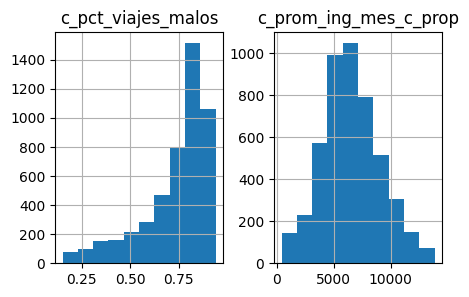

In [49]:
Xt[mc].hist(figsize=(5,3))

In [50]:
print(Xt.shape)
Xt.head()

(4818, 9)


,id_taxi,fh_mes,c_ticket_prom,c_num_meses_activo,c_prom_ing_mes_c_prop,c_prom_ing_mes_s_prop,c_pct_viajes_malos,c_distancia_promedio,c_pct_cash
0,4820,2019-05-01,24.267708,6.0,10184.348333,9593.570000,0.644162,3.993241,0.565811
1,834,2016-03-01,13.902426,6.0,11545.965000,10599.353333,0.868954,1.927943,0.469870
2,5464,2014-12-01,12.096020,6.0,3874.758333,3847.475000,0.881894,2.206946,0.892846
3,5382,2022-09-01,35.346118,6.0,10167.900000,9215.085000,0.374276,4.689745,0.147481
4,3354,2022-01-01,13.774170,4.0,4315.906667,3865.105000,0.848237,1.844314,0.414958


### Discreto 

In [51]:
for v in vard:
    train[v] = train[v].fillna('MISSING')

#### Encoding 

In [52]:
oh = OneHotEncoder(drop='if_binary',sparse_output=False)
oh.fit(train[vard])
train[oh.get_feature_names_out()] = oh.transform(train[vard])

In [53]:
train.head(2)

,id_taxi,fh_mes,d_debajo_prom_ing,c_ticket_prom,c_num_meses_activo,c_prom_ing_mes_c_prop,c_prom_ing_mes_s_prop,c_pct_viajes_malos,c_distancia_promedio,d_empresa,...,d_mes_3,d_mes_4,d_mes_5,d_mes_6,d_mes_7,d_mes_8,d_mes_9,d_mes_10,d_mes_11,d_mes_12
0,4820,2019-05-01,False,24.267708,6,10184.348333,9593.570000,0.644162,3.993241,E137,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,834,2016-03-01,False,13.902426,6,11545.965000,10599.353333,0.868954,1.927943,E176,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [54]:
vard = oh.get_feature_names_out().tolist()

## Integración de datos 

In [55]:
Xt = Xt[um+mc].merge(train[um+vard+vart],on=um,how='inner')

In [56]:
Xt.head()

,id_taxi,fh_mes,c_pct_viajes_malos,c_prom_ing_mes_c_prop,d_debajo_prom_ing_True,d_empresa_E117,d_empresa_E122,d_empresa_E125,d_empresa_E131,d_empresa_E133,...,d_mes_4,d_mes_5,d_mes_6,d_mes_7,d_mes_8,d_mes_9,d_mes_10,d_mes_11,d_mes_12,fuga
0,4820,2019-05-01,0.644162,10184.348333,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1,834,2016-03-01,0.868954,11545.965000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2,5464,2014-12-01,0.881894,3874.758333,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0
3,5382,2022-09-01,0.374276,10167.900000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0
4,3354,2022-01-01,0.848237,4315.906667,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0


## Poder predictivo 

In [59]:
sk = SelectKBest(k=len(mc+vard))
sk.fit(Xt[mc+vard],Xt[vart[0]])

SelectKBest(k=30)

<Axes: >

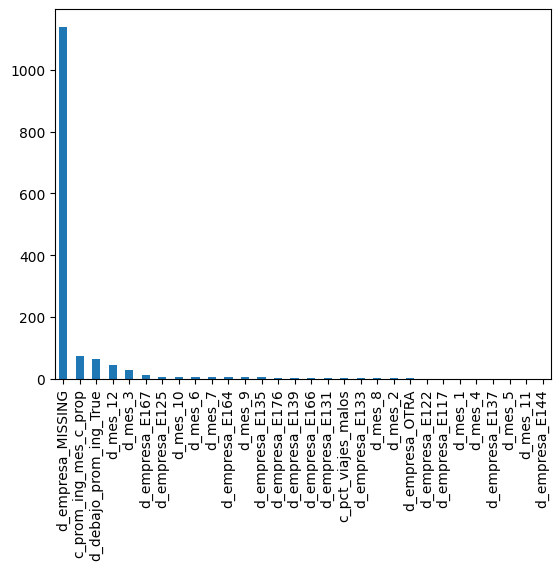

In [67]:
pd.Series(dict(zip(mc+vard,sk.scores_))).sort_values(ascending=False).plot(kind='bar')

In [68]:
sk = SelectKBest(k=5)
sk.fit(Xt[mc+vard],Xt[vart[0]])

SelectKBest(k=5)

In [71]:
best = [v for v,s in zip(mc+vard,sk.get_support()) if s]
best

['c_prom_ing_mes_c_prop',
 'd_debajo_prom_ing_True',
 'd_empresa_MISSING',
 'd_mes_3',
 'd_mes_12']

## Cambio de escala $\mathcal{X}_{[0,1]}$

In [72]:
X = Xt[best].copy()
sc = MinMaxScaler()
sc.fit(X)
Xs = pd.DataFrame(sc.transform(X),columns=X.columns)

## Híper-parametrización

In [73]:
mod = MLPClassifier()

In [74]:
hp = {"hidden_layer_sizes" : [(a,b,) for a in range(2,6) for b in range(2,6)],
"activation" : ['identity', 'logistic', 'tanh', 'relu'],
"solver" : ['lbfgs', 'sgd', 'adam'],
"learning_rate" : ['constant', 'invscaling', 'adaptive'],
"max_iter" : [1000]
}
reduce(lambda x,y:x*y,[len(hp[i]) for i in hp]) 

576

In [75]:
grid = RandomizedSearchCV(param_distributions=hp,
                          estimator=mod,
                          n_iter=50,
                          cv=5,
                          scoring='roc_auc',
                          n_jobs=-1)
grid.fit(Xs,Xt[vart[0]])

/Users/josegustavofuentescabrera/Documents/anahuac/aprendizaje_supervisado/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/josegustavofuentescabrera/Documents/anahuac/aprendizaje_supervisado/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/josegustavofuentescabrera/Documents/anahuac/aprendizaje_supervisado/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:545: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing

RandomizedSearchCV(cv=5, estimator=MLPClassifier(), n_iter=50, n_jobs=-1,
                   param_distributions={'activation': ['identity', 'logistic',
                                                       'tanh', 'relu'],
                                        'hidden_layer_sizes': [(2, 2), (2, 3),
                                                               (2, 4), (2, 5),
                                                               (3, 2), (3, 3),
                                                               (3, 4), (3, 5),
                                                               (4, 2), (4, 3),
                                                               (4, 4), (4, 5),
                                                               (5, 2), (5, 3),
                                                               (5, 4), (5, 5)],
                                        'learning_rate': ['constant',
                                                          'invscaling',
                                                          'adaptive'],
                                        'max_iter': [1000],
                                        'solver': ['lbfgs', 'sgd', 'adam']},
                   scoring='roc_auc')

In [76]:
grid.best_score_,grid.best_params_

(np.float64(0.8315119716884423),
 {'solver': 'adam',
  'max_iter': 1000,
  'learning_rate': 'adaptive',
  'hidden_layer_sizes': (5, 3),
  'activation': 'logistic'})

## Aprendizaje $\vec{\theta} = \{w_{ij}\}$

In [77]:
mod = grid.best_estimator_
mod

MLPClassifier(activation='logistic', hidden_layer_sizes=(5, 3),
              learning_rate='adaptive', max_iter=1000)

In [79]:
mod.fit(Xs, Xt[vart[0]])

MLPClassifier(activation='logistic', hidden_layer_sizes=(5, 3),
              learning_rate='adaptive', max_iter=1000)

## Pesos de la red $\vec{\theta}$

In [80]:
[w.shape for w in mod.coefs_]

[(5, 5), (5, 3), (3, 1)]

In [90]:
for v in [v for v in data.columns if v[:2]=='d_']:
    valid[v] = valid[v].fillna('MISSING')
valid[vard] = oh.transform(valid[[v for v in data.columns if v[:2]=='d_']])
Xv = valid[mc].copy()
Xv[vard] = oh.transform(valid[[v for v in data.columns if v[:2]=='d_']])
Xv = pd.DataFrame(sc.transform(Xv[best]),columns=best)
Xv[um+vart] = valid[um+vart]
Xv = Xv[um+vart+best]


In [91]:
Xv.head()

,id_taxi,fh_mes,fuga,c_prom_ing_mes_c_prop,d_debajo_prom_ing_True,d_empresa_MISSING,d_mes_3,d_mes_12
0,2740,2019-05-01,0,0.343466,1.0,0.0,0.0,0.0
1,3072,2018-12-01,0,0.319314,1.0,0.0,0.0,1.0
2,6635,2016-09-01,0,0.574344,0.0,0.0,0.0,0.0
3,6870,2023-03-01,0,0.412641,1.0,0.0,1.0,0.0
4,2983,2018-05-01,0,0.291905,1.0,0.0,0.0,0.0


In [93]:
Xt['proba'] = mod.predict_proba(Xs)[:,1]
Xv['proba'] = mod.predict_proba(Xv[best])[:,1]

In [95]:
print('AUC train:',roc_auc_score(Xt[vart[0]],mod.predict_proba(Xs)[:,1]))
print('AUC valid:',roc_auc_score(Xv[vart[0]],mod.predict_proba(Xv[best])[:,1]))

AUC train: 0.834269483471176
AUC valid: 0.8418974517140834


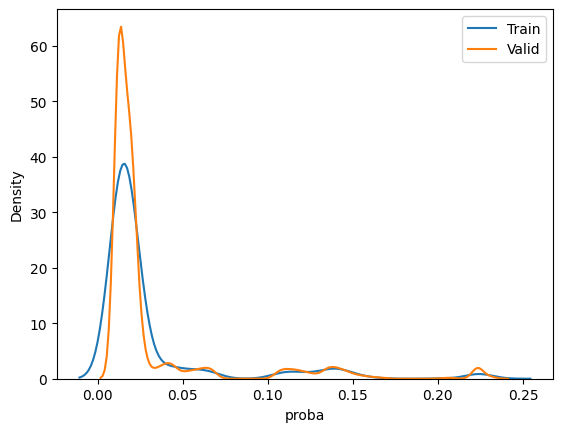

In [96]:
sns.kdeplot(Xt['proba'], label='Train')
sns.kdeplot(Xv['proba'], label='Valid')
plt.legend()

In [112]:
cubo = pd.concat([Xt.assign(muestra='ent'),Xv.assign(muestra='val')],ignore_index=True)
cubo['r_proba'] =pd.cut(cubo['proba'], bins=5, include_lowest=True).astype(str)

In [115]:
cubo = cubo[['r_proba','muestra']+vart+um[:1]].groupby(['r_proba']+vart+['muestra']).count().reset_index()

In [116]:
cubo.to_clipboard(index=False)